----
# 0. Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
import time
import pickle
from imageio import imread
from sklearn.metrics.pairwise import rbf_kernel

----
# 1. Data

## 1.1 Random Data

In [ ]:
n = 50000 #data points
d = 32  #data dimensionality

#Random Data : (d,n)
X = np.random.normal(0,1,(d,n))
X = X/np.linalg.norm(X,keepdims=True,axis=0)

#Query : (d,1)
q = np.random.normal(0,1,(d,1))
q = q/np.linalg.norm(q,keepdims=True,axis=0)

## 1.2 Image Data

In [2]:
data = None
fname = "imnet-100_color_hist.p"
with open(fname, 'rb') as f:
    data = pickle.load(f)

In [3]:
data['all_vecs'].shape
X = data['all_vecs'].T
#X = X/np.linalg.norm(X,keepdims=True,axis=0)

q_index = 32
q = X[:,q_index:q_index+1]
#X = X[:,1:]
d,n = X.shape

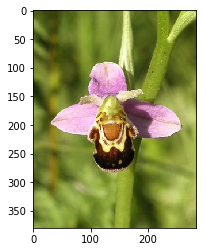

In [4]:
#print(q)
plt.imshow(imread(data['fnames'][q_index]))
plt.show()

-----
# 2. LSH

In [ ]:
b = 200 #hash bits
M = 30  #number of permutations

k = 5  #k-NN

In [ ]:
#Random Hash Vectors : (b,d)
R = np.random.normal(0,1,(b,d)) 

# Permuations : (M,b)
# Each row is a permutation of indices 0,1,...,M-1
Sigma = []
for _ in range(M):
    Sigma.append(np.random.permutation(b))
Sigma = np.array(Sigma)

In [ ]:
# Hash of Data : (b,n)
# Each column is the hash of a data point
def get_hash(R,X):
    tmp = R@X #inner product
    H = np.zeros(tmp.shape,dtype=np.int8) # 1 byte
    H[tmp>=0] = 1
    del tmp
    return H

In [ ]:
H_data = get_hash(R,X)  #(b,n)
H_q    = get_hash(R,q)  #(b,1)

In [ ]:
#Permute Rows: (M,b,n)
def permute(H,Sigma):
    assert(Sigma.shape[1]==H.shape[0])
    M = Sigma.shape[0]
    H_permute = []
    for i in range(M):
         H_permute.append(H[Sigma[i],:]) #permute rows
    H_permute = np.array(H_permute)
    assert(H_permute[0].sum() == H_permute[-1].sum())
    return H_permute

In [ ]:
H_data_permute = permute(H_data,Sigma) #(M,b,n)
H_q_permute    = permute(H_q,Sigma)    #(M,b,1)

In [ ]:
# Interpret axis 1 as bit string: (M,n)
def bitstr2float(H_permute):
    b = H_data_permute.shape[1]
    pos = np.exp2(np.arange(b-1,-1,-1)).reshape(1,-1,1)
    V = (H_permute*pos).sum(axis=1) #broadcase
    return V

In [ ]:
V_data = bitstr2float(H_data_permute)  #(M,n)
V_q    = bitstr2float(H_q_permute)     #(M,1)

In [ ]:
V_data_sort_idx = np.argsort(V_data,axis=-1) # (M,n)
V_data_sort_val = np.sort(V_data,axis=-1)    # (M,n)
i = int(M/2)
j = int(n/3)
assert(V_data[i,V_data_sort_idx[i][j]] == V_data_sort_val[i,j])

In [ ]:
# M Binary searches
t_start = time.time()
ans = []
for i in range(M):
    val_idx = np.searchsorted(V_data_sort_val[i],V_q[i])[0]
    idx = V_data_sort_idx[i,val_idx]
    assert(V_data[i,idx] == V_data_sort_val[i,val_idx])
    ans.append(idx)
ans = np.array(ans)
t_end = time.time()
print(t_end-t_start)

In [ ]:
#Get top-k
hds = []
for i in range(M):
    hd = hamming(H_q[:,0],H_data[:,ans][:,i])
    hds.append(hd)
hds = np.array(hds)
ans2 = ans[hds.argsort()][:k]

------
# 3. Analysis

**Check Hamming distance**

In [ ]:
#all
_sum = 0
for i in range(n):
    _sum += hamming(H_q[:,0],H_data[:,i])
print(_sum/n)

In [ ]:
#selected : M
_sum = 0
for i in range(M):
    _sum += hamming(H_q[:,0],H_data[:,ans][:,i])
print(_sum/M)

In [ ]:
#selected : k
_sum = 0
for i in range(k):
    _sum += hamming(H_q[:,0],H_data[:,ans2][:,i])
print(_sum/M)

**Check Inner Product**

In [5]:
#all .reshape(1,-1)
_all = []
for i in range(n):
    #ip = np.inner(q[:,0],X[:,i])
    #ip = np.linalg.norm(q[:,0]-X[:,i])
    ip = float(rbf_kernel(q[:,0].reshape(1,-1),X[:,i].reshape(1,-1),gamma=1e-9))
    _all.append(ip)
_all = np.array(_all)
print(_all.mean())

0.5076059592432357


In [ ]:
#selected : M
_sel_M = []
for i in range(M):
    ip = np.inner(q[:,0],X[:,ans][:,i])
    _sel_M.append(ip)
_sel_M = np.array(_sel_M)
print(_sel_M.mean())

In [ ]:
#selected : k
_sel_k = []
for i in range(k):
    ip = np.inner(q[:,0],X[:,ans2][:,i])
    _sel_k.append(ip)
_sel_k = np.array(_sel_k)
print(_sel_k.mean())

In [ ]:
plt.hist(_all,alpha=0.3,label="all")
plt.hist(_sel_M,label="selected:M")
plt.legend()
plt.show()

In [ ]:
plt.hist(_all,alpha=0.3,density=True,label="all")
plt.hist(_sel_M,alpha=0.5,density=True,label="selected:M")
plt.hist(_sel_k,alpha=0.5,density=True,label="selected:k")
plt.legend()
plt.show()

------

**Check Distance Preservation**

In [ ]:
#all
ips = []
hds = []
for i in range(n):
    ip = np.inner(q[:,0],X[:,i])
    hd = hamming(H_q[:,0],H_data[:,i])
    ips.append(ip)
    hds.append(hd)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
plt.scatter(ips,hds,s=1)
plt.xlabel("Inner Product")
plt.ylabel("Hamming Distance")
plt.show()

-----

In [ ]:
#Query
print(data['fnames'][q_index])
q

In [ ]:
ans2

In [ ]:
#LSH
print(data['fnames'][4658])
print(data['fnames'][5496])

In [6]:
#Linear
closest = _all.argsort()[::-1]
closest

array([32, 36, 79, 78, 74, 15, 67, 65, 81, 57, 85, 89, 47, 28, 72, 45, 92,
        2, 94, 30, 11, 24, 98,  8,  1, 56,  9, 21, 16, 27, 52, 42, 90, 68,
       58, 53, 23, 93, 63, 10, 99,  5, 48, 14, 62, 33, 31, 60, 41, 51, 29,
       70, 37, 19, 43, 66, 59, 61, 73, 44, 82, 87, 39,  7, 76, 64, 83, 88,
       97, 55, 13, 71,  3, 54,  0, 12, 80,  4, 26, 20, 17, 34, 46, 95, 84,
       86, 40, 35,  6, 49, 91, 18, 50, 77, 22, 75, 69, 38, 96, 25],
      dtype=int64)

./imnet-100/ILSVRC2010_val_00000033.JPEG


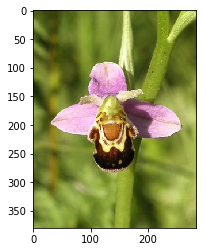

In [7]:
print(data['fnames'][closest[0]])
#print(X[:,closest[0]])
plt.imshow(imread(data['fnames'][closest[0]]))
plt.show()

./imnet-100/ILSVRC2010_val_00000037.JPEG


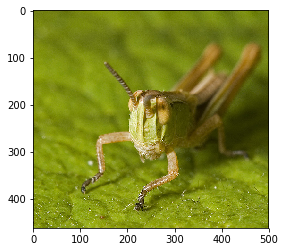

In [8]:
print(data['fnames'][closest[1]])
#print(X[:,closest[1]])
plt.imshow(imread(data['fnames'][closest[1]]))
plt.show()

./imnet-100/ILSVRC2010_val_00000080.JPEG


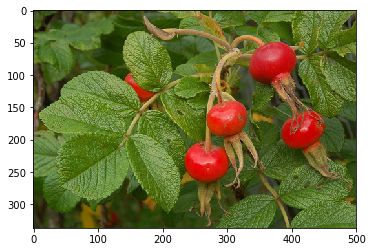

In [9]:
print(data['fnames'][closest[2]])
#print(X[:,closest[2]])
plt.imshow(imread(data['fnames'][closest[2]]))
plt.show()

./imnet-100/ILSVRC2010_val_00000026.JPEG


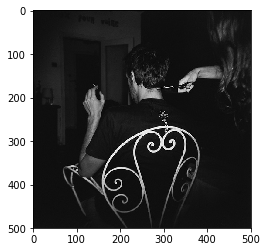

In [10]:
print(data['fnames'][closest[-1]])
#print(X[:,closest[-1]])
plt.imshow(imread(data['fnames'][closest[-1]]))
plt.show()